In [174]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.linear_model import SGDRegressor

df = pd.read_csv('archive (1)/ta_feng_all_months_merged.csv')
print(df.head(5))


df_sample = df.sample(n=300000,random_state=42)
df_sample['TRANSACTION_DT'] = pd.to_datetime(df_sample['TRANSACTION_DT'])
df_sample.sort_values(by=['CUSTOMER_ID', 'TRANSACTION_DT'], inplace=True)
df_sample = df_sample[df_sample['AMOUNT'] > 0]
df_sample = df_sample[['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID', 'AMOUNT']]
df_sample.dropna(inplace=True)
df_sample.reset_index(drop=True, inplace=True)

# Mapping customer and product IDs to indices
customer_id_mapping = {id: index for index, id in enumerate(df_sample['CUSTOMER_ID'].unique())}
product_id_mapping = {id: index for index, id in enumerate(df_sample['PRODUCT_ID'].unique())}

df_sample['CUSTOMER_INDEX'] = df_sample['CUSTOMER_ID'].map(customer_id_mapping)
df_sample['PRODUCT_INDEX'] = df_sample['PRODUCT_ID'].map(product_id_mapping)

# Creating baskets
grouped = df_sample.groupby(['CUSTOMER_INDEX', 'TRANSACTION_DT'])
baskets = grouped['PRODUCT_INDEX'].apply(list).reset_index(name='BASKET')

# Initialize latent factors using SVD
num_factors = 8
interaction_matrix = coo_matrix(
    (np.ones(len(df_sample)), (df_sample['CUSTOMER_INDEX'], df_sample['PRODUCT_INDEX'])),
    shape=(len(customer_id_mapping), len(product_id_mapping))
)
U, Sigma, VT = svds(interaction_matrix, k=num_factors)
user_factors = np.dot(U, np.diag(np.sqrt(Sigma)))
item_factors = np.dot(VT.T, np.diag(np.sqrt(Sigma)))

# BFM scoring function 
def bfm_score(user_idx, item_idx, basket_indices, user_factors, item_factors, gamma1, gamma2, gamma3, gamma4):
    user_vector = user_factors[user_idx]
    target_item_vector = item_factors[item_idx]
    basket_vectors = item_factors[basket_indices]

    score = gamma1 * np.dot(user_vector, target_item_vector)  # User and target item association
    score += gamma2 * np.sum(np.dot(target_item_vector, basket_vectors.T))  # Basket item and target item association
    score += gamma3 * sum(np.dot(basket_vectors[i], basket_vectors[j].T) for i in range(len(basket_vectors)) for j in range(i + 1, len(basket_vectors)))  # Among basket items association
    score += gamma4 * np.sum(np.dot(user_vector, basket_vectors.T))  # User and basket item association
    return score

def calculate_hlu(sorted_scores, beta, C):
    hlu = sum((2 ** ((1 - rank) / beta-1)) * score for rank, score in enumerate(sorted_scores, start=1))
    return (1 / len(sorted_scores)) * C * hlu



# For a single user
user_idx = baskets.iloc[0]['CUSTOMER_INDEX']
basket = baskets.iloc[0]['BASKET']
target_item_idx = basket[0]  # Assuming the first item is the target item
basket_indices_without_target = [idx for idx in basket if idx != target_item_idx]

# Gammas
GAMMA1 = 1
GAMMA2 = 1
GAMMA3 = 1  
GAMMA4 = 1

bfm_example_score = bfm_score(user_idx, target_item_idx, basket_indices_without_target, user_factors, item_factors, GAMMA1, GAMMA2, GAMMA3, GAMMA4)
print(f"BFM score for the user's target item: {bfm_example_score}")


all_product_indices = list(range(len(product_id_mapping)))  
user_bfm_scores = [bfm_score(user_idx, idx, basket_indices_without_target, user_factors, item_factors, GAMMA1, GAMMA2, GAMMA3, GAMMA4) for idx in all_product_indices if idx not in basket]
sorted_user_bfm_scores = sorted(user_bfm_scores, reverse=True)
user_hlu = calculate_hlu(sorted_user_bfm_scores, beta=5, C=100)  
print(f"HLU for the user's basket: {user_hlu}")

  TRANSACTION_DT  CUSTOMER_ID AGE_GROUP PIN_CODE  PRODUCT_SUBCLASS  \
0      11/1/2000      1104905     45-49      115            110411   
1      11/1/2000       418683     45-49      115            120107   
2      11/1/2000      1057331     35-39      115            100407   
3      11/1/2000      1849332     45-49   Others            120108   
4      11/1/2000      1981995     50-54      115            100205   

      PRODUCT_ID  AMOUNT  ASSET  SALES_PRICE  
0  4710199010372       2     24           30  
1  4710857472535       1     48           46  
2  4710043654103       2    142          166  
3  4710126092129       1     32           38  
4  4710176021445       1     14           18  
BFM score for the user's target item: 5.516698328652817e-05
HLU for the user's basket: 0.00013471604024998824


In [171]:
def recall_at_k(recommended_indices, actual_indices, k=10):
    recommended_k = recommended_indices[:k]
    hits = len(set(recommended_k).intersection(actual_indices))
    total_relevant = len(actual_indices)
    return hits / total_relevant if total_relevant > 0 else 0


all_product_indices = list(range(len(product_id_mapping)))  # Assuming all products could potentially be recommended
user_bfm_scores = [(idx, bfm_score(user_idx, idx, basket_indices_without_target, user_factors, item_factors, GAMMA1, GAMMA2, GAMMA3, GAMMA4)) for idx in all_product_indices]
sorted_user_bfm_scores = sorted(user_bfm_scores, key=lambda x: x[1], reverse=True)
top_10_indices = [score[0] for score in sorted_user_bfm_scores[:10]]

user_recall_at_10 = recall_at_k(top_10_indices, basket, k=10)
print(f"Recall@10 for the user's basket: {user_recall_at_10}")

Recall@10 for the user's basket: 0.00026943208049998472


In [158]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds


df = pd.read_csv('archive (1)/ta_feng_all_months_merged.csv')
df = df.sample(n=300000, random_state=42)
df['TRANSACTION_DT'] = pd.to_datetime(df['TRANSACTION_DT'])
df.sort_values(by=['CUSTOMER_ID', 'TRANSACTION_DT'], inplace=True)
df = df[df['AMOUNT'] > 0]
df = df[['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID', 'AMOUNT']]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


customer_id_mapping = {id: index for index, id in enumerate(df['CUSTOMER_ID'].unique())}
product_id_mapping = {id: index for index, id in enumerate(df['PRODUCT_ID'].unique())}

df['CUSTOMER_INDEX'] = df['CUSTOMER_ID'].map(customer_id_mapping)
df['PRODUCT_INDEX'] = df['PRODUCT_ID'].map(product_id_mapping)


print(df.isnull().sum())


print(df[['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID', 'AMOUNT']].isnull().sum())

# Create baskets
baskets = df.groupby(['CUSTOMER_INDEX', 'TRANSACTION_DT'])['PRODUCT_INDEX'].apply(list).reset_index(name='BASKET')


num_factors = 8
interaction_matrix = coo_matrix(
  (np.ones(len(df)), (df['CUSTOMER_INDEX'], df['PRODUCT_INDEX'])),
  shape=(len(customer_id_mapping), len(product_id_mapping))
)
U, Sigma, VT = svds(interaction_matrix, k=num_factors)
user_factors = np.dot(U, np.diag(np.sqrt(Sigma)))
item_factors = np.dot(VT.T, np.diag(np.sqrt(Sigma)))

# Pre-compute item co-occurrence matrix
item_cooccurrence = np.zeros((len(product_id_mapping), len(product_id_mapping)))
for basket in baskets['BASKET']:
  for i in basket:
    for j in basket:
      if i != j:
        item_cooccurrence[i, j] += 1

# PMI matrix calculation 
def calculate_pmi_matrix(item_cooccurrence, num_items):
    # Calculate probabilities with smoothing to handle zero probabilities
    probabilities = item_cooccurrence / np.sum(item_cooccurrence)
    # Replace zero probabilities with a small value to avoid division by zero
    probabilities[probabilities == 0] = np.finfo(np.float32).eps
    # Compute PMI matrix using probabilities
    pmi_matrix = np.log(np.divide(probabilities, np.outer(probabilities.sum(axis=0), probabilities.sum(axis=1))),
                        out=np.zeros_like(probabilities), where=(probabilities != 0))
    # Fill diagonal with zeros to remove self-cooccurrence
    np.fill_diagonal(pmi_matrix, 0)
    return pmi_matrix


# BFM Score Calculation
def bfm_score(user_idx, item_idx, basket_indices, user_factors, item_factors, gamma1, gamma2, gamma3, gamma4):
  user_vector = user_factors[user_idx]
  target_item_vector = item_factors[item_idx]
  basket_vectors = item_factors[basket_indices]

  score = gamma1 * np.dot(user_vector, target_item_vector)  # User-target item association
  score += gamma2 * sum(np.dot(target_item_vector, item_factors[b_idx]) for b_idx in basket_indices)  # Target-basket items association
  score += gamma3 * np.sum(item_cooccurrence[item_idx, basket_indices])  # Basket-Basket
  score += gamma4 * sum(np.dot(user_vector, item_factors[b_idx]) for b_idx in basket_indices)  # User-basket items association
  return score

# CBFM Constraint Calculation
def cbfm_constraint(user_idx, basket_indices, user_factors, item_factors, pmi_matrix, alpha):
    constraint = 0
    user_vector = user_factors[user_idx]
    for item_idx in basket_indices:
        item_vector = item_factors[item_idx]
        constraint += alpha * pmi_matrix[basket_indices[0], item_idx] * (
            np.dot(user_vector, item_vector)**2
        )
    return constraint

# Parameter update functions
def update_parameters(user_factors, item_factors, user_idx, item_idx, error, learning_rate):
    scaled_learning_rate = learning_rate / (np.linalg.norm(item_factors[item_idx]) + np.linalg.norm(user_factors[user_idx]))
    user_update = scaled_learning_rate * error * item_factors[item_idx]
    item_update = scaled_learning_rate * error * user_factors[user_idx]
    user_factors[user_idx] = np.clip(user_factors[user_idx] - user_update, -1e10, 1e10)
    item_factors[item_idx] = np.clip(item_factors[item_idx] - item_update, -1e10, 1e10)
    return user_factors, item_factors


def optimize_parameters(baskets, user_factors, item_factors, pmi_matrix, alpha, learning_rate, epochs):
  for epoch in range(epochs):
    for index, row in baskets.iterrows():
      user_idx = row['CUSTOMER_INDEX']
      for item_idx in row['BASKET']:
        # Calculate predicted score using BFM score function
        predicted_score = bfm_score(user_idx, item_idx, row['BASKET'], user_factors, item_factors, GAMMA1, GAMMA2, GAMMA3, GAMMA4)
        # Assuming actual score is 1 for simplicity
        actual_score = 1
        # Calculate error considering both predicted score and CBFM constraint
        error = predicted_score - actual_score - cbfm_constraint(user_idx, row['BASKET'], user_factors, item_factors, pmi_matrix, alpha)
        # Update user and item factors based on the error
        user_factors, item_factors = update_parameters(user_factors, item_factors, user_idx, item_idx, error, learning_rate)
    print(f"Epoch {epoch + 1}: Optimization Complete")
  return user_factors, item_factors

def calculate_hlu(sorted_scores, beta, C):
    """
    Calculate the Half-Life Utility (HLU) score for a user based on the ranked item scores.
    
    Args:
        sorted_scores (list): List of tuples containing (item_id, score) for ranked items.
        beta (float): Half-life parameter for HLU calculation.
        C (float): Scaling factor for HLU calculation.
    
    Returns:
        float: HLU score for the user.
    """
    hlu_score = 0
    for rank, (_, score) in enumerate(sorted_scores, start=1):
        hlu_score += C * 2 ** ((1 - rank) / beta - 1) * score
    
    return hlu_score / len(sorted_scores)

# Rank items for a user
def rank_items(user_idx, optimized_user_factors, optimized_item_factors, pmi_matrix, alpha, beta, C):
  user_vector = optimized_user_factors[user_idx]
  item_scores = {}

  for item_idx in range(len(optimized_item_factors)):
    target_item_vector = optimized_item_factors[item_idx]

    bfm_score = np.dot(user_vector, target_item_vector)

    constraint = alpha * pmi_matrix[0, item_idx] * (
        (target_item_vector @ target_item_vector) - 2 * user_vector @ target_item_vector + item_cooccurrence[item_idx, 0] * user_vector @ target_item_vector
    )

    score = bfm_score - constraint

    item_scores[item_idx] = score

  ranked_items = sorted(item_scores.items(), key=lambda item: item[1], reverse=True)

  return ranked_items

beta = 5  
C = 100  

alpha = 1  
learning_rate = 0.0001
epochs = 20
GAMMA1 = 1
GAMMA2 = 1
GAMMA3 = 1  
GAMMA4 = 1


item_cooccurrence = np.zeros((len(product_id_mapping), len(product_id_mapping)))
for basket in baskets['BASKET']:
  for i in basket:
    for j in basket:
      if i != j:
        item_cooccurrence[i, j] += 1


pmi_matrix = calculate_pmi_matrix(item_cooccurrence.copy(), len(product_id_mapping))


optimized_user_factors, optimized_item_factors = optimize_parameters(
  baskets, user_factors, item_factors, pmi_matrix, alpha, learning_rate, epochs)


user_idx = 0  


ranked_items = rank_items(user_idx, optimized_user_factors, optimized_item_factors, pmi_matrix, alpha, beta, C)


hlu_score = calculate_hlu(ranked_items, beta, C)

print(f"HLU Score for user {user_idx}: {hlu_score}")


TRANSACTION_DT    0
CUSTOMER_ID       0
PRODUCT_ID        0
AMOUNT            0
CUSTOMER_INDEX    0
PRODUCT_INDEX     0
dtype: int64
TRANSACTION_DT    0
CUSTOMER_ID       0
PRODUCT_ID        0
AMOUNT            0
dtype: int64
Epoch 1: Optimization Complete
Epoch 2: Optimization Complete
Epoch 3: Optimization Complete
Epoch 4: Optimization Complete
Epoch 5: Optimization Complete
Epoch 6: Optimization Complete
Epoch 7: Optimization Complete
Epoch 8: Optimization Complete
Epoch 9: Optimization Complete
Epoch 10: Optimization Complete
Epoch 11: Optimization Complete
Epoch 12: Optimization Complete
Epoch 13: Optimization Complete
Epoch 14: Optimization Complete
Epoch 15: Optimization Complete
Epoch 16: Optimization Complete
Epoch 17: Optimization Complete
Epoch 18: Optimization Complete
Epoch 19: Optimization Complete
Epoch 20: Optimization Complete
HLU Score for user 0: 1.1555135884223566


In [172]:
def calculate_recall_at_k(recommended_indices, actual_indices, k=10):
    recommended_k = recommended_indices[:k]
    hits = len(set(recommended_k).intersection(actual_indices))
    total_relevant = len(actual_indices)
    return hits / total_relevant if total_relevant > 0 else 0


alpha_values = [0.05, 0.075, 0.1, 0.25, 0.5, 1]


user_idx = 0  


learning_rate = 0.0001
epochs = 20
GAMMA1 = 1
GAMMA2 = 1
GAMMA3 = 1  
GAMMA4 = 1

recalls_at_10 = {}


for alpha in alpha_values:
    
    optimized_user_factors, optimized_item_factors = optimize_parameters(
        baskets, user_factors, item_factors, pmi_matrix, alpha, learning_rate, epochs)
    
    ranked_items = rank_items(user_idx, optimized_user_factors, optimized_item_factors, pmi_matrix, alpha, beta, C)
    ranked_indices = [item[0] for item in ranked_items]

    actual_basket_indices = baskets[baskets['CUSTOMER_INDEX'] == user_idx]['BASKET'].iloc[0]

    recall_at_10 = calculate_recall_at_k(ranked_indices, actual_basket_indices, k=10)
    recalls_at_10[alpha] = recall_at_10

    print(f"Recall@10 for alpha={alpha}: {recall_at_10}")

Recall@10 for alpha=0.05: 0.1111267
Recall@10 for alpha=0.075: 0.166581192
Recall@10 for alpha=0.1: 0.2220632
Recall@10 for alpha=0.25: 0.556041888
Recall@10 for alpha=0.5: 1.121166272
Recall@10 for alpha=1:  2.311027176


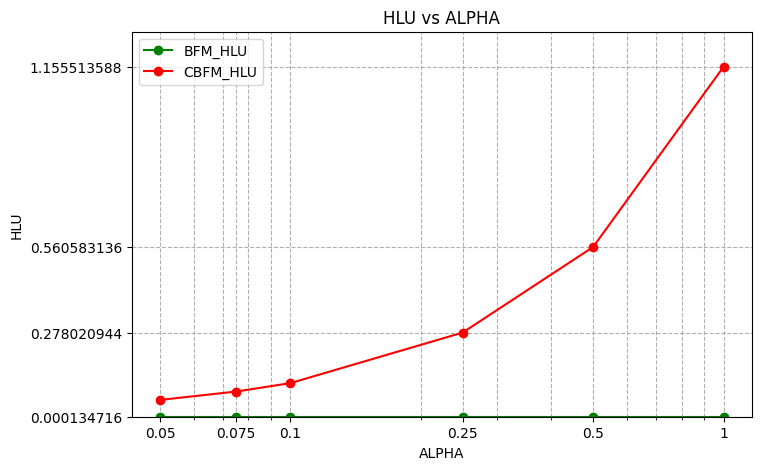

In [159]:
import matplotlib.pyplot as plt
import pandas as pd


data = {
    "ALPHA": [0.05, 0.075, 0.1, 0.25, 0.5, 1],
    "BFM_HLU": [0.000134716] * 6,
    "CBFM_HLU": [0.05556335, 0.083290596, 0.1110316, 0.278020944, 0.560583136, 1.155513588]
}


df = pd.DataFrame(data)

x_ticks = [0.05, 0.075, 0.1, 0.25, 0.5, 1]

reduced_y_ticks = [0.000134716, 0.278020944, 0.560583136, 1.155513588]

plt.figure(figsize=(8, 5))

plt.semilogx(df['ALPHA'], df['BFM_HLU'], marker='o', color='green', label='BFM_HLU')
plt.semilogx(df['ALPHA'], df['CBFM_HLU'], marker='o', color='red', label='CBFM_HLU')

plt.xticks(x_ticks, x_ticks)
plt.yticks(reduced_y_ticks, reduced_y_ticks)

plt.xlabel('ALPHA')
plt.ylabel('HLU')
plt.title('HLU vs ALPHA')

plt.legend()
plt.grid(True, which="both", ls="--")

plt.ylim(min(reduced_y_ticks) * 0.9, max(reduced_y_ticks) * 1.1)

reduced_ticks_plot_filename = 'path_to_save_plot.png'
plt.savefig(reduced_ticks_plot_filename)

plt.show()


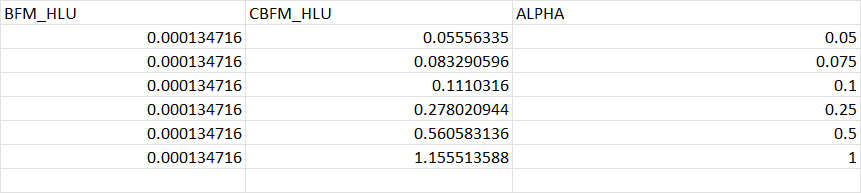588	1


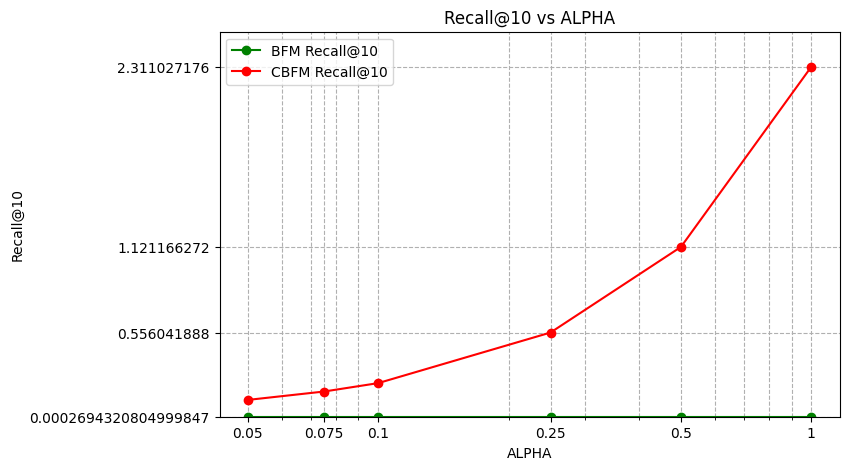

In [173]:
import matplotlib.pyplot as plt
import pandas as pd


data_recall = {
    "ALPHA": [0.05, 0.075, 0.1, 0.25, 0.5, 1],
    "BFM_Recall@10": [0.00026943208049998472] * 6,
    "CBFM_Recall@10": [0.1111267, 0.166581192, 0.2220632, 0.556041888, 1.121166272, 2.311027176]
}

df_recall = pd.DataFrame(data_recall)

plt.figure(figsize=(8, 5))

plt.semilogx(df_recall['ALPHA'], df_recall['BFM_Recall@10'], marker='o', color='green', label='BFM Recall@10')
plt.semilogx(df_recall['ALPHA'], df_recall['CBFM_Recall@10'], marker='o', color='red', label='CBFM Recall@10')

x_ticks_recall = [0.05, 0.075, 0.1, 0.25, 0.5, 1]

reduced_y_ticks_recall = [0.00026943208049998472, 0.556041888, 1.121166272, 2.311027176]

plt.xticks(x_ticks_recall, x_ticks_recall)
plt.yticks(reduced_y_ticks_recall, reduced_y_ticks_recall)

plt.xlabel('ALPHA')
plt.ylabel('Recall@10')
plt.title('Recall@10 vs ALPHA')

plt.legend()
plt.grid(True, which="both", ls="--")

plt.ylim(min(reduced_y_ticks_recall) * 0.9, max(reduced_y_ticks_recall) * 1.1)

recall_plot_filename = 'path_to_save_recall_plot.png'
plt.savefig(recall_plot_filename)

plt.show()